In [6]:
pip install torchviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
from tkinter import X
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchviz import make_dot

# 定义 Vision Transformer 模型
class VisionTransformer(nn.Module):
    def __init__(self, num_classes=10, num_layers=12, num_heads=8, hidden_dim=768, mlp_dim=3072, patch_size=16, img_size=224):
        super().__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim
        self.mlp_dim = mlp_dim
        self.patch_size = patch_size
        self.img_size = img_size

        # 创建补丁嵌入层
        self.patch_embeddings = nn.Conv2d(in_channels=3, # 输入通道数  
                                           out_channels=hidden_dim, # 输出通道数 
                                           kernel_size=patch_size, # 卷积核大小
                                           stride=patch_size) # 步长

        # 位置嵌入，(img_size // patch_size) ** 2 是图像被划分的补丁数量，为什么呢，因为图像被划分为 patch_size * patch_size 的补丁，所以补丁数量就是 img_size // patch_size * img_size // patch_size (1,196,768)
        self.position_embeddings = nn.Parameter(torch.zeros(1, (img_size // patch_size) ** 2 + 1, hidden_dim))

        # 添加可学习的分类token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, hidden_dim)) 

        # Transformer 层
        self.transformer_blocks = nn.ModuleList(
            [nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads) for _ in range(num_layers)] # 12个 Transformer 层
        )

        # 分类头
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # 创建补丁并进行嵌入
        x = self.patch_embeddings(x)  # (batch_size, hidden_dim, num_patches_y, num_patches_x)
        print(f'position_embeddings后: {x.shape}')  # (1,768,14,14)
        x = x.flatten(2).transpose(1, 2)  # flatten(2)默认对tensor最后两个维度进行展平，(batch_size, num_patches, hidden_dim)

        # 添加分类token
        batch_size = x.shape[0] 
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # (batch_size, 1, hidden_dim)
        x = torch.cat((cls_tokens, x), dim=1)  # (batch_size, 1 + num_patches, hidden_dim)

        # 添加位置嵌入
        x += self.position_embeddings

        # 通过 Transformer 层
        for transformer in self.transformer_blocks: 
            x = transformer(x)


        print(f'transformer后: {x.shape}')
        # 使用 class token 作为输入
        x = x[:, 0]  # 只使用CLS token进行分类 (batch_size, hidden_dim)
        x = self.fc(x)  # 分类头
        return x

# 生成随机图像的函数
def generate_random_image(size=(3, 224, 224)):
    return np.random.rand(*size).astype(np.float32)

# 主函数
def main():
    # 配置模型
    model = VisionTransformer(num_classes=1000)
    model.eval()  # 设置为评估模式

    # 随机生成输入图像
    random_image = generate_random_image()

    # 转换为张量并添加批次维度
    input_tensor = torch.from_numpy(random_image).unsqueeze(0)  # (1, 3, 224, 224)

    # 进行前向计算
    with torch.no_grad():  # 禁用梯度计算
        logits = model(input_tensor)

    # 打印输出
    print('Logits:', logits.shape)

    # 可视化模型结构
    # y = model(input_tensor)
    # dot = make_dot(y, params=dict(model.named_parameters()))
    # dot.format = 'png'
    # dot.render('vit_model_structure', cleanup=True, view=False)  # 增加 dpi 值以提高清晰度


    # # 可视化输入图像
    # plt.imshow(random_image.transpose(1, 2, 0))
    # plt.title('Randomly Generated Image')
    # plt.axis('off')
    # plt.show()

if __name__ == "__main__":
    main()

position_embeddings后: torch.Size([1, 768, 14, 14])
transformer后: torch.Size([1, 197, 768])
Logits: torch.Size([1, 1000])


In [8]:
224//16

14

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

输入图像尺寸: torch.Size([1, 3, 224, 224])
Transformer模块输出尺寸: torch.Size([1, 197, 768])
Logits尺寸: torch.Size([1, 1000])
Predicted class: Egyptian cat


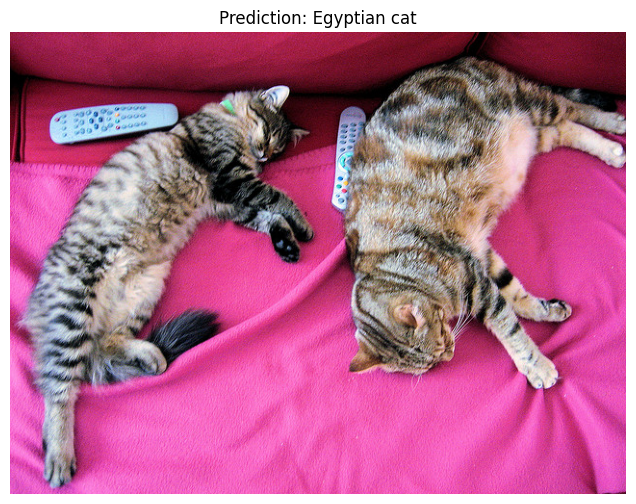

In [ ]:
#梯子必须开启
# 使用transformers库的ViT模型进行图像预测
from transformers import ViTFeatureExtractor, ViTForImageClassification
from PIL import Image
import requests
import torch
import matplotlib.pyplot as plt

def predict_with_transformers_vit():
    # 加载预训练的ViT模型和特征提取器
    feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
    model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

    # 下载示例图片
    url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
    image = Image.open(requests.get(url, stream=True).raw) # 下载图片并打开

    # 预处理图像
    inputs = feature_extractor(images=image, return_tensors="pt") #pt表示pytorch tensor, 这里返回的是一个字典
    print(f"输入图像尺寸: {inputs['pixel_values'].shape}") # 输入图像尺寸: torch.Size([1, 3, 224, 224])

    # 进行预测，获取Transformer模块的输出
    with torch.no_grad():
        # 使用钩子函数获取Transformer模块的输出
        transformer_output = None

        def hook_fn(module, input, output):
            nonlocal transformer_output # 声明非局部变量
            transformer_output = output

        # 注册钩子到Transformer模块
        hook = model.vit.encoder.register_forward_hook(hook_fn) # 注册到第1个Transformer模块

        # 前向传播
        outputs = model(**inputs) 

        # 移除钩子
        hook.remove()

    # 打印Transformer模块输出尺寸
    print(f"Transformer模块输出尺寸: {transformer_output.last_hidden_state.shape}") # Transformer模块输出尺寸: torch.Size([1,197,768])

    # 获取预测结果
    logits = outputs.logits
    print(f"Logits尺寸: {logits.shape}") # Logits尺寸: torch.Size([1,1000])
    predicted_class_idx = logits.argmax(-1).item() # 取最大值的索引作为预测类别

    # 获取预测的类别名称
    predicted_class = model.config.id2label[predicted_class_idx]

    # 打印结果
    print(f"Predicted class: {predicted_class}")

    # 显示图像
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.title(f'Prediction: {predicted_class}')
    plt.axis('off')
    plt.show()

# 调用函数
predict_with_transformers_vit()
